# Libraries

In [1]:
import os
import cv2
import sys
import uuid
import joblib
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import concurrent.futures
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

In [2]:
# Attaching project directory
sys.path.append(os.path.dirname(os.getcwd()))

# Pathing imports
from src import GetPath, MotionHistoryImage

In [3]:
SIZE = (64, 64)
NORMALIZE = False

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [4]:
# DATA_PATH = GetPath().data()

# MHI_DATA = os.path.join(DATA_PATH, 'preprocess', 'mhi_right_tail')
# MHI_CNTRS_SAMPLE = os.path.join(MHI_DATA, 'samples', 'mhi_contour_sampling.csv')

# Local Path
D_PATH = 'D:/fish_behavior'
MHI_DATA = os.path.join(D_PATH, 'data', 'preprocess', 'mhi_right_tail')
MHI_CNTRS_SAMPLE = os.path.join(MHI_DATA, 'samples', 'mhi_contour_sampling.csv')

# Inspecting Data Samples for B1 batch - 15 frame

In [5]:
datasets = MotionHistoryImage(mhi_dir=MHI_DATA)
print(f"Total experiment datasets: {len(datasets)}")

Total experiment datasets: 4014


# Data Preprocessing Approach


### What Machine Learning Model Can See
The data sample are sampled from B1 batch video both normal and abnormal condition. To mimic the real human inspection, a window of 60 seconds from the start time will be sample across video.


### Computer Vision Approach: Motion History Image (MHI)
Below are the picture taken based on the activity of hybrid grouper. This technique is also known as Motion History Image or Holistic Approach. In addition, to show the history, I have apply an order to the intensity of light picture. In simpler word, if the traces are whitter or more visible, it indicates that that is the latest motion by hybrid grouper


### Advantages
One major advantages in this technique is the approach compress the data from 1920x1080x60x60 [(size video) x (frame per second) x (time windows)] to simply 640x480 [(size image)].


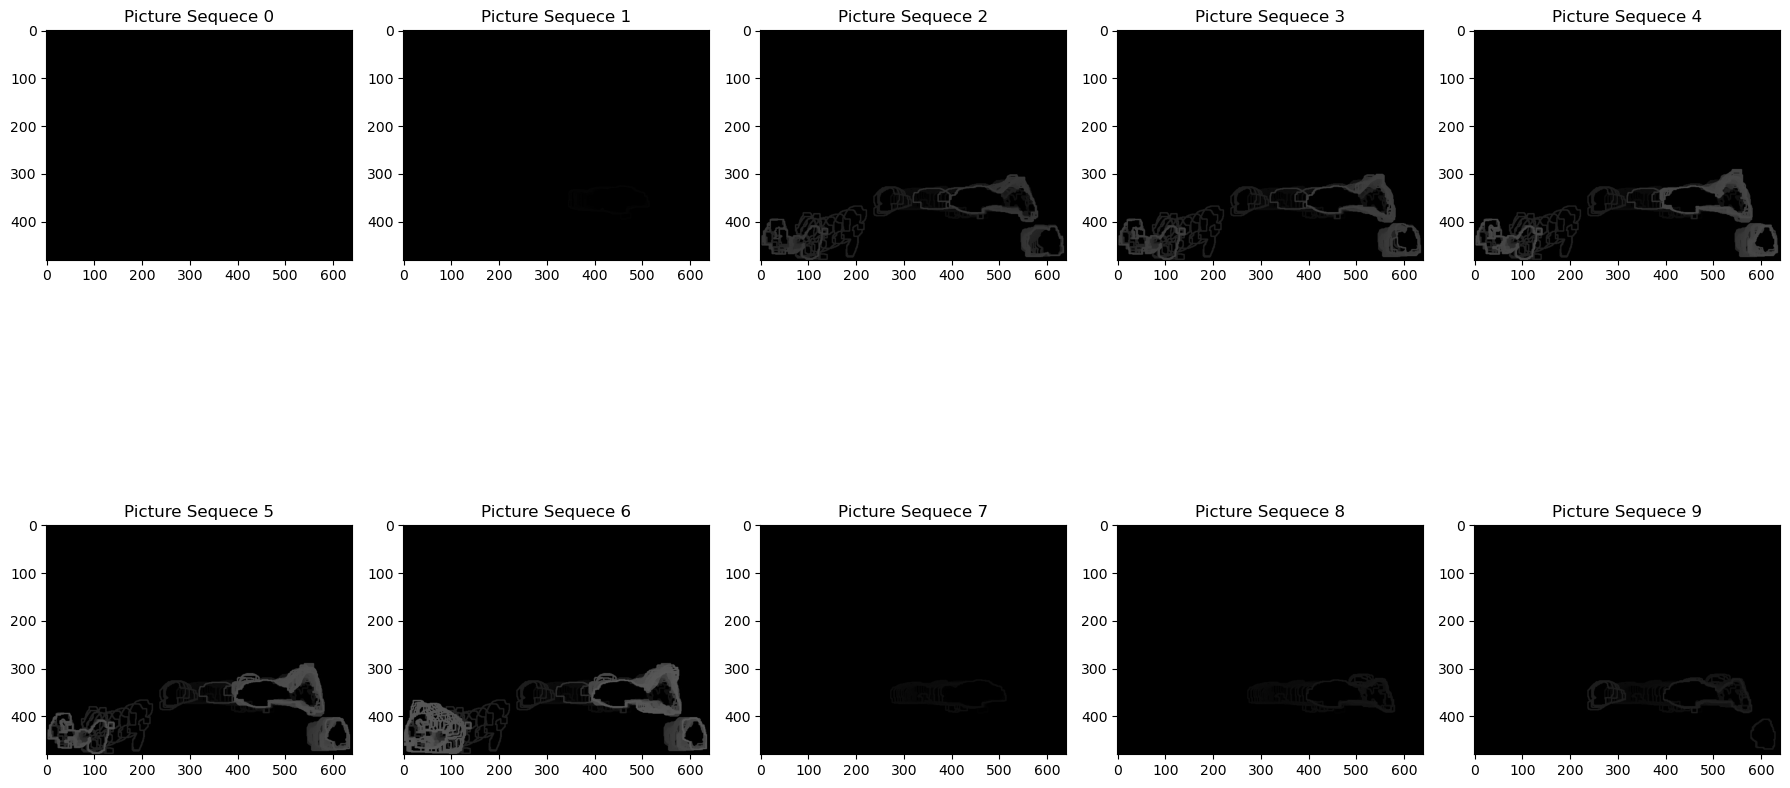

In [6]:
################
### Plotting ###
################
# Loading image path
try:
    folder = "D:/fish_behavior/data/preprocess/mhi_binary/POC/B1A_1620"
    file = os.listdir(folder)
    images = [cv2.imread(os.path.join(folder, image)) for image in file]

    # Calculate the number of rows and columns for the grid
    num_images = len(images)
    rows = 2 # int(np.sqrt(num_images))  # Assuming a square grid (adjust if needed)
    cols = 5 # int(np.ceil(num_images / rows))  # Round up for incomplete rows
    images_seq = [i for i in range(0, len(images), int(len(images)/(2*5)))]

    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(18, 12))  # Adjust figure size as needed

    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(images[images_seq[idx]])
        ax.set_title(f"Picture Sequece {idx}")

    # Adjust layout (optional)
    plt.tight_layout()

    # Display the plot
    plt.show()

except:
    pass

# Experiment: Abnormal by level 0 ~ 10

## Data Quality

Each of the start frame for the windows 60 seconds are randomized in batch video of experiment B1 for both normal and abnormal activity. This is to increase the quality and also to mimic the human interaction for the data in use for machine learning. For example, image if something happen in a lab and you were called to inspect the situation. The first thing you do would be inspect the fish for a certain length of time. Here, we defined the inspection time for machine learning as 60 seconds as to determine the situation as fast as possible with the maximum time as possible. In addition, the randomized start frame also mimic the situation where expert can be called anytime.

In [7]:
# Convert time to seconds
def time_to_seconds(time_str):
    if not isinstance(time_str, str):
        time_str = str(time_str)

    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s
    

In [8]:
# Inspecting MHI start time generated to end time
# For example, if the column "start_time_sample" starts from 00:03:19 and ends at 00:04:00, this means the model loss initial 19 seconds of earlier data
# For column "time_frame", this indicate either it is experiment conducted specifically for abnormal experiment (lack oxygen)
start_frame = pd.read_csv(MHI_CNTRS_SAMPLE)
start_frame

,experiment,time_frame,start_time_sample,end_time,abn_level
0,ABN_B2,00:34:00,00:33:04,00:34:00,0
1,ABN_B2,00:35:00,00:34:08,00:35:00,0
2,ABN_B2,00:40:00,00:39:27,00:40:00,0
3,ABN_B2,00:41:00,00:40:17,00:41:00,0
4,ABN_B2,00:42:00,00:41:07,00:42:00,0
...,...,...,...,...,...
6119,ABN_B1,02:00:00,01:59:07,02:00:00,10
6120,ABN_B1,02:00:00,01:59:08,02:00:00,10
6121,ABN_B1,02:00:00,01:59:16,02:00:00,10
6122,ABN_B1,02:00:00,01:59:25,02:00:00,10


Below shows the normal distribution of start seconds for each of the condition

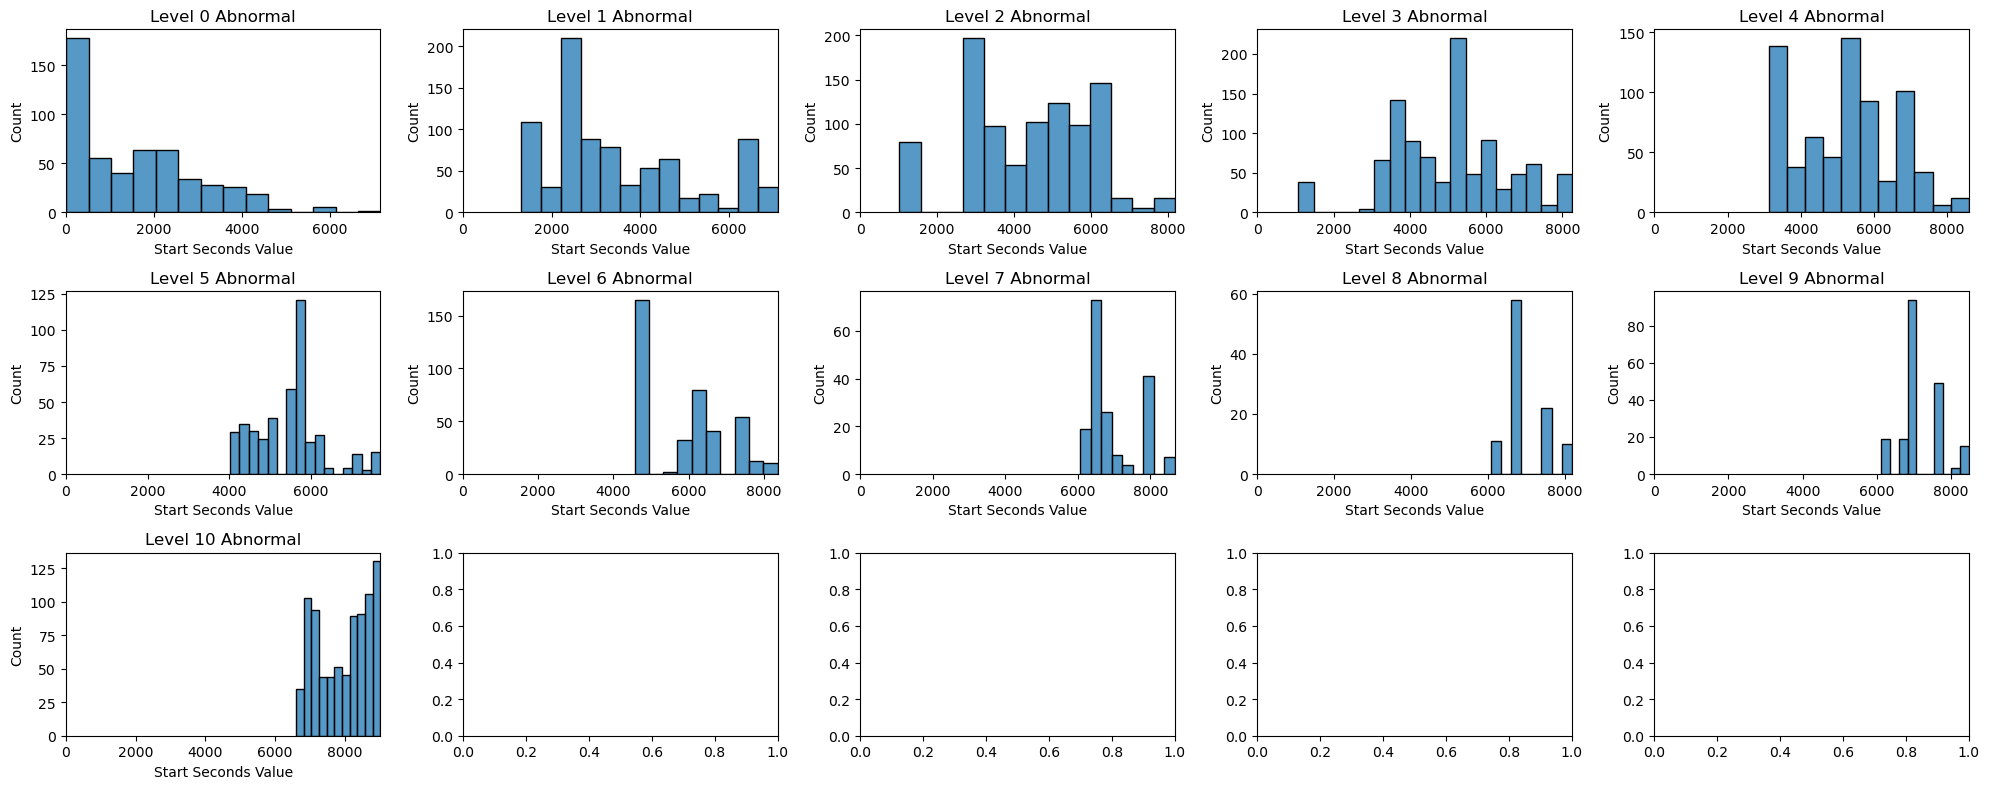

In [9]:
######################################################
### Plotting: Start Frame Distribution (Histogram) ###
######################################################

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 8))

for level, ax in zip(sorted(start_frame['abn_level'].unique()), axes.flatten()):
    sns.histplot(
        start_frame[start_frame['abn_level']==level]['start_time_sample'].apply(time_to_seconds), ax=ax
    )
    ax.set_title(f"Level {level} Abnormal")
    ax.set_xlabel('Start Seconds Value')
    ax.set_xlim(0, start_frame[start_frame['abn_level']==level]['start_time_sample'].apply(time_to_seconds).max())

# Adjust layout (optional)
plt.tight_layout()

# Display the plot
plt.show()

### Checking number of data for each batch

In [11]:
# Loading batch 1 experiment data
b1_dataset = MotionHistoryImage(experiment="B1", mhi_dir=MHI_DATA)
print(f"Data for experiment B1: {len(b1_dataset)}")

# Loading batch 2 experiment data
b2_dataset = MotionHistoryImage(experiment="B2", mhi_dir=MHI_DATA)
print(f"Data for experiment B2: {len(b2_dataset)}")

# Loading batch 2 experiment data
b3_dataset = MotionHistoryImage(experiment="B3", mhi_dir=MHI_DATA)
print(f"Data for experiment B3: {len(b3_dataset)}")


Data for experiment B1: 1671
Data for experiment B2: 1435
Data for experiment B3: 860


In [12]:
# images = []
# labels = []
# for idx in np.random.randint(1, len(b1_dataset), 100):
#     image, label = b1_dataset.__getitem__(idx, size=SIZE, normalize=False)
#     images.append(image)
#     labels.append(label)


def distance_image(im, im2):
    d1 = cv2.matchShapes(im,im2,cv2.CONTOURS_MATCH_I1,0) 
    d2 = cv2.matchShapes(im,im2,cv2.CONTOURS_MATCH_I2,0) 
    d3 = cv2.matchShapes(im,im2,cv2.CONTOURS_MATCH_I3,0)
    return d1, d2, d3

def calculate_huMoments(image):
    # Calculate Moments
    moments = cv2.moments(image)

    # Calculate Hu Moments
    huMoments = cv2.HuMoments(moments)
    huMoments = huMoments[:, 0]

    import math
    for i in range(len(huMoments)):
        huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))

    return huMoments

'level_5'

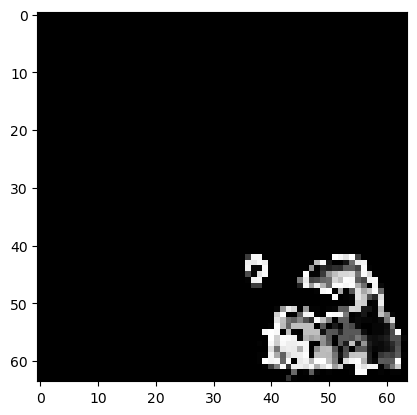

In [13]:
image, label = b1_dataset.__getitem__(random.randint(0, len(b1_dataset)), size=SIZE, normalize=NORMALIZE)
plt.imshow(image, cmap='gray')
label

In [14]:
images = []
labels = []

# Add experiment B1
for idx in range(len(b1_dataset)):
    image, label = b1_dataset.__getitem__(idx, size=SIZE, normalize=NORMALIZE)
    images.append(image.flatten())
    labels.append(label)

# Add experiment B2
for idx in range(len(b1_dataset)):
    image, label = b1_dataset.__getitem__(idx, size=SIZE, normalize=NORMALIZE)
    images.append(image.flatten())
    labels.append(label)

images = np.array(images)

In [15]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(images, labels)
knn.score(images, labels)

1.0

In [16]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(images, labels)
lda.score(images, labels)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# Create the pipeline
SPRF = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

MPRF = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=3)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

SLRF = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', LinearDiscriminantAnalysis(n_components=3)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

MLRF = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', LinearDiscriminantAnalysis(n_components=3)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Fit the pipeline
SPRF.fit(images, labels)
MPRF.fit(images, labels)
SLRF.fit(images, labels)
MLRF.fit(images, labels)

In [ ]:
images_val = []
labels_val = []

# Add experiment B1
for idx in range(len(b3_dataset)):
    image, label = b3_dataset.__getitem__(idx, size=SIZE, normalize=NORMALIZE)
    images_val.append(image.flatten())
    labels_val.append(label)

models = ['knn', 'lda', 'SPRF', 'MPRF', 'SLRF', 'MLRF']
for model in models:
    print(f"{model} validation accuracy: {eval(model).score(images_val, labels_val)}")

In [ ]:
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier

pca = PCA()
pca.fit(images)

# Getting the cumulative variance

var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))
#print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

In [ ]:
images = PCA(n_components=k).fit_transform(images)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=RANDOM_STATE)

clf = LogisticRegression(random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

print(f"Model Training Accuracy: {clf.score(X_train, y_train)}")
print(f"Model Test Accuracy: {clf.score(X_test, y_test)}")

In [ ]:
images = []
labels = []

# Add experiment B1
for idx in range(len(b3_dataset)):
    image, label = b3_dataset.__getitem__(idx, size=SIZE, normalize=NORMALIZE)
    images.append(image.flatten())
    labels.append(label)

images = PCA(n_components=k).fit_transform(images)
print(f"Model Validation Accuracy: {clf.score(images, labels)}")

In [ ]:
# data_stores = {}
# for batch, experiment in enumerate([b1_dataset, b2_dataset, b3_dataset]):
#     data_stores[f"B{batch+1}"] = {
#         'images': [],
#         'images_train': [],
#         'images_test': [],
#         'labels': [],
#         'labels_train': [],
#         'labels_test': []
#     }

#     for idx in range(len(experiment)):
#         image, label = experiment.__getitem__(idx, size=SIZE, normalize=False)
#         data_stores[f"B{batch+1}"]['images'].append(image.flatten())
#         data_stores[f"B{batch+1}"]['labels'].append(convert_level(label))

# Data Store Class

In [ ]:
class DataStores:
    def __init__(self, batchs=["B1", "B2", "B3"], pca_model=PCA(), n_components=100, normalize=False):
        self.batchs = batchs
        self.experiments = {}
        self.pca_model = pca_model
        self.n_components = n_components
        self.normalize = normalize

        #
        self._load_data_()

    def add_experiment(self, batch: str):
        self.experiments[batch] = {
            'images': [],
            'images_train': [],
            'images_test': [],
            'labels': [],
            'labels_train': [],
            'labels_test': []
        }

    def process_image_hu_moments(self, image: np.ndarray):
        if not isinstance(image, np.ndarray) or image.ndim != 2:
            raise ValueError("Input must be a 2D numpy array (grayscale image).")
        
        # Calculate Moments
        moments = cv2.moments(image)
        
        # Calculate Hu Moments
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Process Hu Moments using vectorized operations
        hu_moments = -1 * np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        
        return hu_moments

    def process_image(self, image: np.ndarray):
        features = np.array([])
        features = np.append(features, image.flatten())

        # Feature reduction - PCA
        features = np.append(features, self.pca_model.transform([image.flatten()]))

        # Calculate Moments
        features = np.append(features, self.process_image_hu_moments(image))

        features = np.append(features, np.mean(image))
        features = np.append(features, np.max(image))
        features = np.append(features, np.median(image))
        features = np.append(features, np.sum(image))
        return features
    
    def process_label(self, label: str):
        try:
            # Extract the number after "level_"
            level_number = int(label.split('_')[1])
            
            # Convert to two-digit string
            return int(f"{level_number:02d}")
        except (IndexError, ValueError):
            return "Invalid input"

    def add_data(self, experiment_name: str, image: np.ndarray, label: str, case: str = ""):
        if experiment_name not in self.experiments:
            self.add_experiment(experiment_name)

        images_store = "images"
        labels_store = "labels"

        if case:
            images_store = f"images_{case}"
            labels_store = f"labels_{case}"

        self.experiments[experiment_name][images_store].append(self.process_image(image))
        self.experiments[experiment_name][labels_store].append(self.process_label(label))

    def combine_data(self, experiment1: str, experiment2: str):
        if experiment1 not in self.experiments or experiment2 not in self.experiments:
            return "Not valid combination"
        
        
        experiment_name = f"{experiment1}_{experiment2}"
        # Initialize experiment template
        if experiment_name not in self.experiments:
            self.add_experiment(experiment_name)

        for key in self.experiments[experiment_name].keys():
            self.experiments[experiment_name][key] = self.experiments[experiment1][key] +  self.experiments[experiment2][key]

    def _load_data_(self):
        for batch in self.batchs:
            experiment_data = MotionHistoryImage(experiment=batch, mhi_dir=MHI_DATA)

            # Load all data
            for idx in range(len(experiment_data)):
                image, label = experiment_data.__getitem__(idx, size=SIZE, normalize=self.normalize)
                self.add_data(experiment_name=batch, image=image, label=label)

            # Splitting data
            data_size = len(experiment_data)
            train, test = train_test_split(
                np.arange(data_size), 
                test_size=0.2, 
                random_state=RANDOM_STATE, 
                stratify=experiment_data.labels
            )

            # Train data
            for idx in train:
                image, label = experiment_data.__getitem__(idx, size=SIZE, normalize=self.normalize)
                self.add_data(experiment_name=batch, image=image, label=label, case='train')

            # Test data
            for idx in test:
                image, label = experiment_data.__getitem__(idx, size=SIZE, normalize=self.normalize)
                self.add_data(experiment_name=batch, image=image, label=label, case='test')


    def get_experiment(self, experiment_name: str):
        return self.experiments.get(experiment_name)

In [ ]:
def convert_label(label: str):
    try:
        # Extract the number after "level_"
        level_number = int(label.split('_')[1])
        
        # Convert to two-digit string
        return int(f"{level_number:02d}")
    except (IndexError, ValueError):
        return "Invalid input"

In [ ]:
images = []
labels = {}

# Add experiment B1
for idx in range(len(b2_dataset)):
    image, label = b2_dataset.__getitem__(idx, size=SIZE, normalize=NORMALIZE)
    images.append(image.flatten())
    labels[idx] = convert_label(label)

labels = pd.DataFrame.from_dict(labels, orient='index', columns=['label'])
labels.value_counts()

In [ ]:
# # under sample
# df_minority = labels[labels['label']==8]

# new_df = pd.concat([df_minority, df_minority, df_minority])
# for i in range(11):
#     if i != 8:
#         undersample = labels[labels['label']==i].sample(n=len(df_minority)*3, replace=True, random_state=RANDOM_STATE)
#         new_df = pd.concat([new_df, undersample])

for i in range(11):
    if i==8 or i==7 or i==9 or i==6:
        undersample = labels[labels['label']==i].sample(n=100, replace=True, random_state=RANDOM_STATE)
        new_df = pd.concat([labels, undersample])

In [ ]:
images_train = []
labels_train = []
for idx in new_df.index:
    image, label = b2_dataset.__getitem__(idx, size=SIZE, normalize=NORMALIZE)
    images_train.append(image.flatten())
    labels_train.append(label)

# Fit the pipeline
SPRF.fit(images_train, labels_train)
MPRF.fit(images_train, labels_train)
SLRF.fit(images_train, labels_train)
MLRF.fit(images_train, labels_train)

images_test = []
labels_test = []

# Add experiment B1
for idx in range(len(b2_dataset)):
    image, label = b2_dataset.__getitem__(idx, size=SIZE, normalize=NORMALIZE)
    images_test.append(image.flatten())
    labels_test.append(label)

models = ['knn', 'lda', 'SPRF', 'MPRF', 'SLRF', 'MLRF']
for model in models:
    print(f"{model} training accuracy: {eval(model).score(images_train, labels_train)}")
    print(f"{model} test accuracy: {eval(model).score(images_test, labels_test)}")
    print(f"{model} validation accuracy: {eval(model).score(images_val, labels_val)}")

In [ ]:
images = []
labels = []

# Add experiment B1
for idx in range(len(b1_dataset)):
    image, label = b1_dataset.__getitem__(idx, size=SIZE, normalize=NORMALIZE)
    images.append(image.flatten())
    labels.append(label)

# Add experiment B2
for idx in range(len(b1_dataset)):
    image, label = b1_dataset.__getitem__(idx, size=SIZE, normalize=NORMALIZE)
    images.append(image.flatten())
    labels.append(label)

images = np.array(images)
pca = PCA(n_components=2)
pca.fit(images)

# release memory
images = []
labels = []

In [ ]:
datas = DataStores(pca_model=pca, n_components=2, normalize=NORMALIZE)

# Model Training: Data Preparation On Batch 1 Experiment

In [ ]:
# splitting data to train, test and validation
train, test = train_test_split(np.arange(len(b1_dataset)), test_size=0.2, random_state=RANDOM_STATE, stratify=b1_dataset.labels)
print(f"The data in train: {len(train)} \nThe data in test: {len(test)}")

In [ ]:
# Plot 1: Start Frame Distribution (Histogram)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.histplot(train, ax=axes[0])
axes[0].set_title("Distribution for train sets")
sns.histplot(test, ax=axes[1])
axes[1].set_title("Distribution for test sets")

# Adjust layout (optional)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class ClassificationModel:
    def __init__(self, model: BaseEstimator, model_name: str):
        self.model = model
        self.model_name = model_name
        self.is_trained = False

    def train(self, data_store, experiment_name):
        experiment = data_store.get_experiment(experiment_name)
        if experiment is None:
            raise ValueError(f"Experiment '{experiment_name}' not found in the data store.")

        X_train = experiment['images_train']
        y_train = experiment['labels_train']

        self.model.fit(X_train, y_train)
        self.is_trained = True
        self.last_trained_experiment = experiment_name

        train_accuracy = self.model.score(X_train, y_train)
        print(f"{self.model_name} Training accuracy: {train_accuracy:.4f}")

    def evaluate(self, data_store, experiment_name):
        if not self.is_trained:
            raise ValueError("Model hasn't been trained yet. Call train() first.")

        experiment = data_store.get_experiment(experiment_name)
        if experiment is None:
            raise ValueError(f"Experiment '{experiment_name}' not found in the data store.")

        X_test = experiment['images_test']
        y_test = experiment['labels_test']

        test_accuracy = self.model.score(X_test, y_test)
        y_pred = self.model.predict(X_test)

        print(f"{self.model_name} Test accuracy: {test_accuracy:.4f}")
        print("\n-----CLASSIFICATION REPORT-----\n")
        print(classification_report(y_test, y_pred))

        return y_test, y_pred

    def plot_confusion_matrix(self, y_true, y_pred):
        disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, xticks_rotation='vertical')
        disp.figure_.suptitle(f"{self.model_name} Confusion Matrix")
        plt.show()

    def run_full_analysis(self, data_store, experiment_name):
        self.train(data_store, experiment_name)
        y_true, y_pred = self.evaluate(data_store, experiment_name)
        self.plot_confusion_matrix(y_true, y_pred)

In [ ]:
# Logistic Regression
lr_model = ClassificationModel(
    LogisticRegression(random_state=RANDOM_STATE, max_iter=10000),
    "Logistic Regression"
)
lr_model.run_full_analysis(datas, 'B1')

# Data Issues
Some of the "level abnormal" are not present in batch 1 experiment, therefore it is not suitable to be used as training.

In [ ]:
# Plotting Countplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x=datas.get_experiment('B1')['labels_train'], ax=axes[0])
axes[0].set_title("Distribution for train sets")
sns.countplot(x=datas.get_experiment('B1')['labels_test'], ax=axes[1])
axes[1].set_title("Distribution for test sets")

# Adjust layout (optional)
plt.tight_layout()

# Display the plot
plt.show()

# Model Training: Data Preparation On Batch 2 Experiment

In [ ]:
# splitting data to train, test and validation
train, test = train_test_split(np.arange(len(b2_dataset)), test_size=0.2, random_state=RANDOM_STATE, stratify=b2_dataset.labels)
print(f"The data in train: {len(train)} \nThe data in test: {len(test)}")

In [ ]:
# Plot 1: Start Frame Distribution (Histogram)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.histplot(train, ax=axes[0])
axes[0].set_title("Distribution for train sets")
sns.histplot(test, ax=axes[1])
axes[1].set_title("Distribution for test sets")

# Adjust layout (optional)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Logistic Regression
lr_model.run_full_analysis(datas, 'B2')

In [ ]:
# Plotting Countplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x=datas.get_experiment('B2')['labels_train'], ax=axes[0])
axes[0].set_title("Distribution for train sets")
sns.countplot(x=datas.get_experiment('B2')['labels_test'], ax=axes[1])
axes[1].set_title("Distribution for test sets")

# Adjust layout (optional)
plt.tight_layout()

# Display the plot
plt.show()

# Model Training: Data Preparation On Batch 3 Experiment

In [ ]:
# splitting data to train, test and validation
train, test = train_test_split(np.arange(len(b3_dataset)), test_size=0.2, random_state=RANDOM_STATE, stratify=b3_dataset.labels)
print(f"The data in train: {len(train)} \nThe data in test: {len(test)}")

In [ ]:
# Plot 1: Start Frame Distribution (Histogram)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.histplot(train, ax=axes[0])
axes[0].set_title("Distribution for train sets")
sns.histplot(test, ax=axes[1])
axes[1].set_title("Distribution for test sets")

# Adjust layout (optional)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Logistic Regression
lr_model.run_full_analysis(datas, 'B3')

In [ ]:
# Plotting Countplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x=datas.get_experiment('B3')['labels_train'], ax=axes[0])
axes[0].set_title("Distribution for train sets")
sns.countplot(x=datas.get_experiment('B3')['labels_test'], ax=axes[1])
axes[1].set_title("Distribution for test sets")

# Adjust layout (optional)
plt.tight_layout()

# Display the plot
plt.show()

# Model Selection

### Training Using Batch 1 and Validation with Batch 1,2 & 3

In [ ]:
# Define the base models
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'SGD Classifier': SGDClassifier(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE, algorithm='SAMME'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(random_state=RANDOM_STATE),
    'Gaussian Naive Bayes': GaussianNB(),
    'Multi-layer Perceptron': MLPClassifier(random_state=RANDOM_STATE)
    # 'XGBoost': xgb.XGBClassifier()
}

# Evaluate the performance of each base model
def train_and_evaluate(name, model, images_train, labels_train, images_test, labels_test):
    le = LabelEncoder()
    labels_train = le.fit_transform((labels_train))
    model.fit(images_train, labels_train)
    label_predict = model.predict(images_test)
    label_predict = le.inverse_transform(label_predict)
    accuracy = accuracy_score(labels_test, label_predict)
    f1 = f1_score(labels_test, label_predict, average='weighted', zero_division=0.0)
    precision = precision_score(labels_test, label_predict, average='weighted', zero_division=0.0)
    recall = recall_score(labels_test, label_predict, average='weighted', zero_division=0.0)
    return [name, accuracy, f1, precision, recall]

def model_selection(experiment='B1'):
    results = []
    with tqdm(total=len(models), desc='Model Training', unit='model') as progress:
        with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
            futures = []
            for name, model in models.items():
                future = executor.submit(
                    train_and_evaluate, 
                    name, 
                    model, 
                    datas.get_experiment(experiment)['images_train'],
                    datas.get_experiment(experiment)['labels_train'],
                    datas.get_experiment(experiment)['images_test'],
                    datas.get_experiment(experiment)['labels_test']
                )
                futures.append(future)

            for future in concurrent.futures.as_completed(futures):
                results.append(future.result())
                future.add_done_callback(lambda p: progress.update())
    
    return results

# run baseline selector
results = model_selection(experiment='B1')

# Sort the results by F1-score in descending order
results = sorted(results, key=lambda x: x[2], reverse=True)

# Print the results
print("Model Performance:")
print("+-----------------------+----------+----------+----------+----------+")
print("| Model                 | Accuracy | F1-score | Precision | Recall   |")
print("+-----------------------+----------+----------+----------+----------+")
for result in results:
    print("| {:<20} | {:.4f}   | {:.4f}   | {:.4f}   | {:.4f}   |".format(*result))
print("+-----------------------+----------+----------+----------+----------+")

# Choose the best model based on the results
best_model = models[results[0][0]]
print(f"The best model is {results[0][0]}")

In [ ]:
def ValidationAllExperiment(model, data_stores, experiment=['B1', 'B2', 'B3']):
    for batch in experiment:
        y_pred = model.predict(data_stores.get_experiment(batch)['images'])
        print(f"Running Validation for Batch {batch}")
        print(f"Model accuracy: {model.score(data_stores.get_experiment(batch)['images'], data_stores.get_experiment(batch)['labels'])}")
        print(f"\n-----CLASSIFICATION REPORT BATCH {batch}-----\n", classification_report(data_stores.get_experiment(batch)['labels'], y_pred, zero_division=0.0))
        disp = ConfusionMatrixDisplay.from_predictions(data_stores.get_experiment(batch)['labels'], y_pred, xticks_rotation='vertical')
        # print(f"Confusion matrix:\n{disp.confusion_matrix}")
        disp.figure_.suptitle(f"Confusion Matrix Batch {batch}")
        plt.show()

ValidationAllExperiment(model=best_model, data_stores=datas)

### Training Using Batch 2 and Validation with Batch 1,2 & 3

In [ ]:
# run baseline selector
results = model_selection(experiment='B2')

# Sort the results by F1-score in descending order
results = sorted(results, key=lambda x: x[2], reverse=True)

# Print the results
print("Model Performance:")
print("+-----------------------+----------+----------+----------+----------+")
print("| Model                 | Accuracy | F1-score | Precision | Recall   |")
print("+-----------------------+----------+----------+----------+----------+")
for result in results:
    print("| {:<20} | {:.4f}   | {:.4f}   | {:.4f}   | {:.4f}   |".format(*result))
print("+-----------------------+----------+----------+----------+----------+")

# Choose the best model based on the results
best_model = models[results[0][0]]
print(f"The best model is {results[0][0]}")

In [ ]:
ValidationAllExperiment(model=best_model, data_stores=datas)

### Training Using Batch 3 and Validation with Batch 1,2 & 3

In [ ]:
# run baseline selector
results = model_selection(experiment='B3')

# Sort the results by F1-score in descending order
results = sorted(results, key=lambda x: x[2], reverse=True)

# Print the results
print("Model Performance:")
print("+-----------------------+----------+----------+----------+----------+")
print("| Model                 | Accuracy | F1-score | Precision | Recall   |")
print("+-----------------------+----------+----------+----------+----------+")
for result in results:
    print("| {:<20} | {:.4f}   | {:.4f}   | {:.4f}   | {:.4f}   |".format(*result))
print("+-----------------------+----------+----------+----------+----------+")

# Choose the best model based on the results
best_model = models[results[0][0]]
print(f"The best model is {results[0][0]}")

In [ ]:
ValidationAllExperiment(model=best_model, data_stores=datas)

### Training Using Batch 1&2 and Validation with Batch 1,2 & 3

In [ ]:
datas.combine_data('B1', 'B2')

In [ ]:
# run baseline selector
results = model_selection(experiment='B1_B2')

# Sort the results by F1-score in descending order
results = sorted(results, key=lambda x: x[2], reverse=True)

# Print the results
print("Model Performance:")
print("+-----------------------+----------+----------+----------+----------+")
print("| Model                 | Accuracy | F1-score | Precision | Recall   |")
print("+-----------------------+----------+----------+----------+----------+")
for result in results:
    print("| {:<20} | {:.4f}   | {:.4f}   | {:.4f}   | {:.4f}   |".format(*result))
print("+-----------------------+----------+----------+----------+----------+")

# Choose the best model based on the results
best_model = models[results[0][0]]
print(f"The best model is {results[0][0]}")

In [ ]:
ValidationAllExperiment(model=best_model, data_stores=datas)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
for k in range(1, 10):

    # Create the pipeline
    pipeline = Pipeline([
        # ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(f_classif, k=k)),  # Select top 10 features
        ('classifier', VotingClassifier(
            estimators=[
                # Create base classifier
                ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)),
                ('svm', SVC(random_state=RANDOM_STATE)),
                ('sgd', SGDClassifier(random_state=RANDOM_STATE)),
                ('rf', RandomForestClassifier(random_state=RANDOM_STATE)),
                ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
                ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE))
            ],
            voting='hard'
        ))
    ])

    # Fit the pipeline
    pipeline.fit(datas.experiments['B1_B2']['images_train'], datas.experiments['B1_B2']['labels_train'])

    train_score = pipeline.score(datas.experiments['B1_B2']['images_train'], datas.experiments['B1_B2']['labels_train'])
    test_score = pipeline.score(datas.experiments['B1_B2']['images_test'], datas.experiments['B1_B2']['labels_test'])
    val_score = pipeline.score(datas.experiments['B3']['images'], datas.experiments['B3']['labels'])

    print(f"---- Features: {k}")
    print(f"Train score: {train_score}")
    print(f"Test score: {test_score}")
    print(f"Validation score: {val_score}")
    print(f"---- End of evaluation {k} features \n")

In [ ]:
ValidationAllExperiment(model=pipeline, data_stores=datas)

# Hyperparameter Tuning

In [ ]:
from skopt import BayesSearchCV

In [ ]:
param_grid = {
    'Logistic Regression': {
        'C': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    },
    'Support Vector Machine': {
        'C': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }
}

### Tuned & Trained On Batch 1

In [ ]:
def tuning_model(model, param_grid, experiment='B1', cv=5, scoring='accuracy', n_jobs=16):
    # Create the grid search object
    grid_search = BayesSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs)

    # Fit the grid search model
    grid_search.fit(data_stores[experiment]['images_train'], data_stores[experiment]['labels_train'])

    # Print the best hyperparameters and the corresponding score
    print('Best hyperparameters: ', grid_search.best_params_)
    print('Best score: ', grid_search.best_score_)

    # Evaluate the model on the test set
    test_score = grid_search.best_estimator_.score(data_stores[experiment]['images_test'], data_stores[experiment]['labels_test'])
    print('Test set accuracy: ', test_score)
    return grid_search.best_estimator_

tuned_model = tuning_model(
    model=best_model,
    param_grid=param_grid['Support Vector Machine'],
    experiment='B1',
    cv=2,
    n_jobs=-1
)

In [ ]:
ValidationAllExperiment(model=tuned_model, data_stores=data_stores)

### Tuned & Train On Batch 2

In [ ]:
tuned_model = tuning_model(
    model=best_model,
    param_grid=param_grid['Support Vector Machine'],
    experiment='B2',
    cv=2,
    n_jobs=50
)

In [ ]:
ValidationAllExperiment(model=tuned_model, data_stores=data_stores)

### Tuned & Train On Batch 3

In [ ]:
tuned_model = tuning_model(
    model=best_model,
    param_grid=param_grid['Support Vector Machine'],
    experiment='B3',
    cv=2,
    n_jobs=-1
)

In [ ]:
ValidationAllExperiment(model=tuned_model, data_stores=data_stores)

# Conclusion

The simple data preprocessing of Human Motion Image (HMI) are sufficient to differentiate between normal and abnormal condition solely due to the reaction of hybrid grouper to the condition. In addition, the model can be further improve by fine tuning model. In addition, we can also increase the validation test.

# Future Improvement

While HMI shown to be successfuly, we can adept advanced preprocessing in the same domain by using optiflow approach.


# Limitation

This approach is solely to differentiate between normal and abnormal condition. However, the video possesed a lot more of potential data to be extract such as fish behaviour of fast swim, hovering, ascending vertical and etc.. This approach may be used to extract the behaviour, however, more time is needed to exactly take the frame time of such condition. We also need to consider the number of behaviour done by the number of hybrid grouper.

# Improvement

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import xgboost as xgb
import concurrent.futures
from tqdm.notebook import tqdm


#
_, labels_train = np.unique(labels_train, return_inverse=True)
_, labels_test = np.unique(labels_test, return_inverse=True)

# Define the base models
models = {
    'Logistic Regression': LogisticRegression(),
    'SGD Classifier': SGDClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Gaussian Naive Bayes': GaussianNB(),
    'XGBoost': xgb.XGBClassifier()
}

# Evaluate the performance of each base model
results = []
# for name, model in models.items():
#     model.fit(images_train, labels_train)
#     label_predict = model.predict(images_test)
#     accuracy = accuracy_score(labels_test, label_predict)
#     f1 = f1_score(labels_test, label_predict, average='micro')
#     precision = precision_score(labels_test, label_predict, average='micro')
#     recall = recall_score(labels_test, label_predict, average='micro')
#     results.append([name, accuracy, f1, precision, recall])

def train_and_evaluate(name, model, images_train, labels_train, images_test, labels_test):
    model.fit(images_train, labels_train)
    label_predict = model.predict(images_test)
    accuracy = accuracy_score(labels_test, label_predict)
    f1 = f1_score(labels_test, label_predict, average='micro')
    precision = precision_score(labels_test, label_predict, average='micro')
    recall = recall_score(labels_test, label_predict, average='micro')
    return [name, accuracy, f1, precision, recall]

with tqdm(total=len(models), desc='Model Training', unit='model') as progress:
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for name, model in models.items():
            future = executor.submit(train_and_evaluate, name, model, images_train, labels_train, images_test, labels_test)
            futures.append(future)

        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())
            future.add_done_callback(lambda p: progress.update())



# Sort the results by F1-score in descending order
results = sorted(results, key=lambda x: x[2], reverse=True)

# Print the results
print("Model Performance:")
print("+-----------------------+----------+----------+----------+----------+")
print("| Model                 | Accuracy | F1-score | Precision | Recall   |")
print("+-----------------------+----------+----------+----------+----------+")
for result in results:
    print("| {:<20} | {:.4f}   | {:.4f}   | {:.4f}   | {:.4f}   |".format(*result))
print("+-----------------------+----------+----------+----------+----------+")

# Choose the best model based on the results
best_model = models[results[0][0]]
print(f"The best model is {results[0][0]}")

### Hyperparameter Tuning

In [ ]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Create the Logistic Regression model
model = LogisticRegression()

# Create the grid search object
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search model
grid_search.fit(images_train, labels_train)

# Print the best hyperparameters and the corresponding score
print('Best hyperparameters: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)

# Evaluate the model on the test set
test_score = grid_search.best_estimator_.score(images_test, labels_test)
print('Test set accuracy: ', test_score)

### Stratified Fold evaluation

In [ ]:
X = []
y = []
for idx in range(len(datasets)):
    image, label = datasets.__getitem__(idx)
    X.append(image.flatten())
    y.append(label)

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Create a stratified k-fold cross-validation iterator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store the accuracy scores
accuracy_scores = []

X = np.array(X)
y = np.array(y)

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train a logistic regression model
    model = LogisticRegression(C=0.1, l1_ratio=0.5, penalty='l2')
    model.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    print(f"Fold accuracy: {accuracy:.3f}")

# Calculate the mean accuracy score
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Mean accuracy: {mean_accuracy:.3f}")

In [ ]:
# model_path = os.path.join(D_PATH, 'data', 'models', 'classification', f"MHI_SGD_{str(uuid.uuid4())}.joblib")
# joblib.dump(grid_search.best_estimator_, model_path)

In [ ]:
model_path = os.path.join(D_PATH, 'data', 'models', 'classification', f"LR_{str(uuid.uuid4())}.joblib")
joblib.dump(grid_search.best_estimator_, model_path)

In [ ]:
models = []

for model in os.listdir(os.path.join(D_PATH, 'data', 'models', 'classification')):
    models.append(os.path.join(D_PATH, 'data', 'models', 'classification', model))

# Demo Version 1

In [ ]:
videos = ABN_B1

In [ ]:
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

In [ ]:
# clf = SGDClassifier(alpha=0.1, l1_ratio=0.5, penalty='l2', loss='log_loss')
clf = LogisticRegression(C=0.1, l1_ratio=0.5, penalty='l2')
clf.fit(X_train, y_train)


In [ ]:
list_frames = [
    '15'
]

# clf = joblib.load(models[-1])

seconds_length = 60
scaler = 0.001

video_path = ABN_B1
cap = cv2.VideoCapture(video_path)
backSub = cv2.createBackgroundSubtractorMOG2(
    varThreshold=200
)
kernel = (5,5)

width = 720
height = 480
text = "Need more time inspection"

# Get the frame rate of the video
fps = cap.get(cv2.CAP_PROP_FPS)

# Convert start_time to seconds
start_seconds = time_to_seconds("00:00:00")

# Calculate the start frame based on start time
start_frame = int(start_seconds * fps)

# Set the capture time in frames
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

hist_frames = {}

ret, old_frame = cap.read()

for fps in list_frames:
    hist_frames[fps] = np.zeros(old_frame.shape[:2], dtype=np.uint8)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

gif_frame = []

while True:
    ret, frame = cap.read()

    if not ret:
        break
    
    # get backsubtraction method
    bs_mask = tools.get_bs(frame, backSub, kernel)

    # get contors
    cntrs = tools.get_contours(old_frame, frame, kernel)

    # current number of frame
    curr_num_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)

    for fps in hist_frames.keys():
        if curr_num_frame % int(fps) == 0:
            # gets holistic background subtraction
            # hist_frames[fps] = cv2.add(hist_frames[fps], bs_mask)

            # get holistic contours
            color = 255 * scaler
            cv2.drawContours(hist_frames[fps], cntrs, -1, (color, color, color), 2)
            gif_frame.append(hist_frames['15'])

        if curr_num_frame % (60*seconds_length) == 0:
            image_input = cv2.resize(hist_frames[fps], (224, 224))
            image_input = cv2.normalize(image_input, None, -1, 1, cv2.NORM_MINMAX)
            image_input = image_input.flatten()
            condition = clf.predict_proba([image_input])

            if condition.size != 0:
                text = "".join([f"ABL{i}:{round(condition[0][i]/1, 2)}" for i in range(len(condition[0]))])

                # text = f"Condition : Abnormal: {round(condition[0], 5)}, Normal: {round(condition[1], 5)}"

            hist_frames[fps] = np.zeros(old_frame.shape[:2], dtype=np.uint8)
            scaler = 0.001

    # handle output
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    win1 = cv2.resize(hist_frames['15'], (width, height))
    # win2 = cv2.resize(hist_frames['30'], (width, height))
    # win3 = cv2.resize(hist_frames['60'], (width, height))

    # display = np.hstack((win1, win2, win3))

    scaler += 0.0001

    cv2.imshow("Original", cv2.resize(frame, (width, height)))
    cv2.imshow("Frames Holistic", win1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Abnormal vs Normal - Old Scenario

In [ ]:
datasets = HistoryMotionImage.Fish_Dataset_Binary()
len(datasets)

In [ ]:
# data preparation
start_frame = {
    'normal':[time_to_seconds(frame) for frame in datasets.get_frame('normal')], 
    'abnormal':[time_to_seconds(frame) for frame in datasets.get_frame('abnormal')]
}

# TODO: Dataframe size and dataset size is not the same, need to inspect why software cannot extract all of the time defined, however, the existing data is sufficient for training
# start frame for both normal and abnormal video
start_frame = pd.DataFrame(start_frame)
start_frame

In [ ]:
# Below shows the normal distribution of start seconds for each of the condition

# Plot 1: Start Frame Distribution (Histogram)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for col, ax in zip(start_frame.columns, axes.flatten()):
    sns.histplot(start_frame[col], ax=ax)
    ax.set_title(f"Distribution of {col} Start Frames")
    ax.set_xlabel('Start Second Value')

# Adjust layout (optional)
plt.tight_layout()

# Display the plot
plt.show()

# Model Training

In [ ]:
train, test = train_test_split(np.arange(len(datasets)), test_size=0.3, random_state=RANDOM_STATE)

### Start Frame Distribution - Data Analysis

In [ ]:
# Plot 1: Start Frame Distribution (Histogram)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.histplot(train, ax=axes[0])
axes[0].set_title("Distribution for train sets")
sns.histplot(test, ax=axes[1])
axes[1].set_title("Distribution for test sets")

# Adjust layout (optional)
plt.tight_layout()

# Display the plot
plt.show()

### Data Preparation

In [ ]:
images_train = []
labels_train = []
for idx in train:
    image, label = datasets.__getitem__(idx)
    images_train.append(image.flatten())
    labels_train.append(label)

images_test = []
labels_test = []
for idx in test:
    image, label = datasets.__getitem__(idx)
    images_test.append(image.flatten())
    labels_test.append(label)

In [ ]:
np.unique(labels_train, return_inverse=True)

### Model Selection

In [ ]:
_, labels_train = np.unique(labels_train, return_inverse=True)
_, labels_test = np.unique(labels_test, return_inverse=True)

results = []

# Define the base models
models = {
    'Logistic Regression': LogisticRegression(),
    'SGD Classifier': SGDClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Gaussian Naive Bayes': GaussianNB(),
    'XGBoost': xgb.XGBClassifier()
}

with tqdm(total=len(models), desc='Model Training', unit='model') as progress:
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for name, model in models.items():
            future = executor.submit(train_and_evaluate, name, model, images_train, labels_train, images_test, labels_test)
            futures.append(future)

        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())
            future.add_done_callback(lambda p: progress.update())

# Sort the results by F1-score in descending order
results = sorted(results, key=lambda x: x[2], reverse=True)

# Print the results
print("Model Performance:")
print("+-----------------------+----------+----------+----------+----------+")
print("| Model                 | Accuracy | F1-score | Precision | Recall   |")
print("+-----------------------+----------+----------+----------+----------+")
for result in results:
    print("| {:<20} | {:.4f}   | {:.4f}   | {:.4f}   | {:.4f}   |".format(*result))
print("+-----------------------+----------+----------+----------+----------+")

# Choose the best model based on the results
best_model = models[results[0][0]]
print(f"The best model is {results[0][0]}")

### Hyperparameter Tuning

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

# Create the SVM model
model = SVC()

# Create the grid search object
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search model
grid_search.fit(images_train, labels_train)

# Print the best hyperparameters and the corresponding score
print('Best hyperparameters: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)

# Evaluate the model on the test set
test_score = grid_search.best_estimator_.score(images_test, labels_test)
print('Test set accuracy: ', test_score)